In [2]:
import numpy as np 
import pandas as pd 

In [2]:
# 导入必要的库
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 读取数据
train = pd.read_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\train.csv')
test = pd.read_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\test.csv')
submission = pd.read_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\sample_submission.csv')

In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train.shape, test.shape, submission.shape

((1460, 81), (1459, 80), (1459, 2))

In [8]:
# 检查缺失数据
missing_data = pd.DataFrame({
    'Train': train.isnull().sum(),
    'Test': test.isnull().sum()
})

# 筛选出有缺失值的列
missing_data = missing_data[missing_data.sum(axis=1) > 0]
print(missing_data)

              Train    Test
Alley          1369  1352.0
BsmtCond         37    45.0
BsmtExposure     38    44.0
BsmtFinSF1        0     1.0
BsmtFinSF2        0     1.0
BsmtFinType1     37    42.0
BsmtFinType2     38    42.0
BsmtFullBath      0     2.0
BsmtHalfBath      0     2.0
BsmtQual         37    44.0
BsmtUnfSF         0     1.0
Electrical        1     0.0
Exterior1st       0     1.0
Exterior2nd       0     1.0
Fence          1179  1169.0
FireplaceQu     690   730.0
Functional        0     2.0
GarageArea        0     1.0
GarageCars        0     1.0
GarageCond       81    78.0
GarageFinish     81    78.0
GarageQual       81    78.0
GarageType       81    76.0
GarageYrBlt      81    78.0
KitchenQual       0     1.0
LotFrontage     259   227.0
MSZoning          0     4.0
MasVnrArea        8    15.0
MasVnrType      872   894.0
MiscFeature    1406  1408.0
PoolQC         1453  1456.0
SaleType          0     1.0
TotalBsmtSF       0     1.0
Utilities         0     2.0


In [10]:
# 分离标签并合并特征
train_labels = train['SalePrice']
features = pd.concat([train.drop('SalePrice', axis=1), test], keys=['train', 'test'])

# 删除缺失数据超过一半或与价格无关的特征
features_to_drop = [
    'Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
    'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
    'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'
]
features.drop(columns=features_to_drop, inplace=True)

In [12]:
features.shape, features.loc['train'].shape, features.loc['test'].shape

((2919, 56), (1460, 56), (1459, 56))

In [14]:
# 缺失值填充和转换特征

# 将 MSSubClass 转为字符串类型
features = features.assign(
    MSSubClass=features['MSSubClass'].astype(str),
    OverallCond=features['OverallCond'].astype(str),
    KitchenAbvGr=features['KitchenAbvGr'].astype(str),
    YrSold=features['YrSold'].astype(str),
    MoSold=features['MoSold'].astype(str)
)

# 填充缺失值，使用最常见值填充分类特征
for col, fill_value in [
    ('MSZoning', features['MSZoning'].mode()[0]),
    ('MasVnrType', features['MasVnrType'].mode()[0]),
    ('Electrical', features['Electrical'].mode()[0]),
    ('KitchenQual', features['KitchenQual'].mode()[0]),
    ('SaleType', features['SaleType'].mode()[0])
]:
    features[col] = features[col].fillna(fill_value)

# 填充缺失值，指定特定含义
features = features.assign(
    LotFrontage=features['LotFrontage'].fillna(features['LotFrontage'].mean()),  # 用均值填充
    Alley=features['Alley'].fillna('NOACCESS'),                                  # 无巷道访问
    TotalBsmtSF=features['TotalBsmtSF'].fillna(0),                               # 无地下室面积
    GarageCars=features['GarageCars'].fillna(0.0),                               # 无车库车位数
    FireplaceQu=features['FireplaceQu'].fillna('NoFP')                           # 无壁炉
)

# 用 "NoBSMT" 填充所有地下室相关的列
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    features[col] = features[col].fillna('NoBSMT')

# 用 "NoGRG" 填充所有车库相关的列
for col in ['GarageType', 'GarageFinish', 'GarageQual']:
    features[col] = features[col].fillna('NoGRG')

# 创建总面积特征并删除单独的地下室、1楼和2楼面积特征
features = features.assign(
    TotalSF=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
).drop(columns=['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'])

In [16]:
features.shape, features.loc['train'].shape, features.loc['test'].shape

((2919, 54), (1460, 54), (1459, 54))

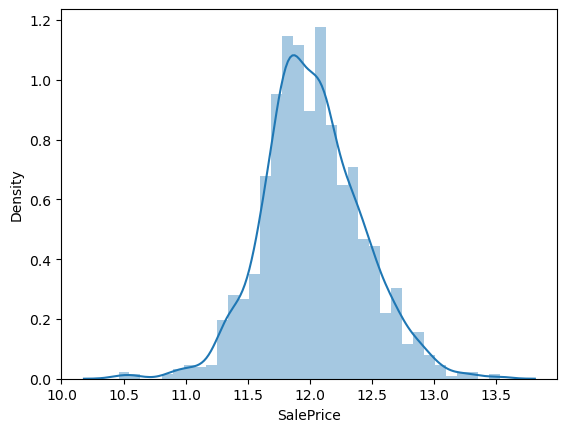

In [18]:
# 标签转换为log并且可视化
import seaborn as sns
train_labels = np.log(train_labels)
ax = sns.distplot(train_labels)

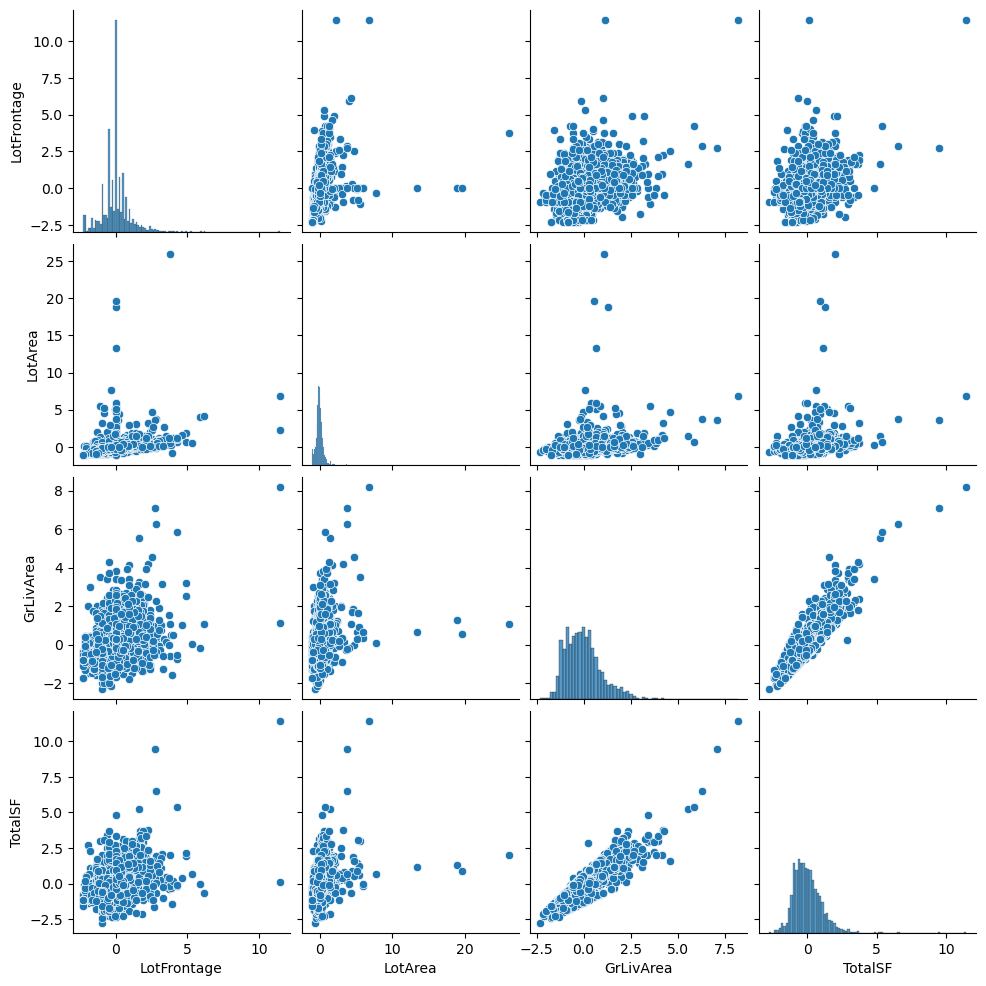

In [20]:
from sklearn.preprocessing import StandardScaler

# 选择数值特征并进行标准化
numeric_features = features[['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
scaler = StandardScaler()
numeric_features_standardized = pd.DataFrame(scaler.fit_transform(numeric_features), columns=numeric_features.columns)

# 绘制标准化后的特征配对图
sns.pairplot(numeric_features_standardized)


In [21]:
from sklearn.preprocessing import LabelEncoder

# 选择分类变量
categorical_features = features.select_dtypes(include=['object']).columns

# 使用 LabelEncoder 对每个分类变量进行编码
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col])
    label_encoders[col] = le  # 保存编码器以便以后使用或逆转编码

In [22]:
features.shape, features.loc['train'].shape, features.loc['test'].shape

((2919, 54), (1460, 54), (1459, 54))

In [23]:
# 复制 features 并替换数值特征为标准化值
features_standardized = features.copy()
features_standardized[numeric_features.columns] = numeric_features_standardized

# 拆分训练集和测试集特征，并去掉 'Id' 列
train_features = features.loc['train'].drop(columns='Id').select_dtypes(include=[np.number]).to_numpy()
test_features = features.loc['test'].drop(columns='Id').select_dtypes(include=[np.number]).to_numpy()

# 拆分标准化后的训练集和测试集特征
train_features_st = features_standardized.loc['train'].drop(columns='Id').select_dtypes(include=[np.number]).to_numpy()
test_features_st = features_standardized.loc['test'].drop(columns='Id').select_dtypes(include=[np.number]).to_numpy()


In [30]:
train_features.shape, test_features.shape

((1460, 53), (1459, 53))

In [32]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# 随机打乱训练集的特征和标签
train_features, train_features_st, train_labels = shuffle(train_features, train_features_st, train_labels, random_state=5)

# 拆分原始特征数据集为训练集和验证集
x_train, x_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.1, random_state=200)

# 拆分标准化特征数据集为训练集和验证集
x_train_st, x_val_st, y_train_st, y_val_st = train_test_split(train_features_st, train_labels, test_size=0.1, random_state=200)


In [40]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
test_features = imputer.fit_transform(test_features)

In [42]:
test_features.shape

(1459, 53)

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
import numpy as np

# 定义缺失值填充器
imputer = SimpleImputer(strategy='mean')

# 填充缺失值
x_train = imputer.fit_transform(x_train)
x_val = imputer.transform(x_val)
x_train_st = imputer.fit_transform(x_train_st)
x_val_st = imputer.transform(x_val_st)

# 定义计算 R2 和 RMSE 的函数
def evaluate_model(model, x_train, y_train, x_val, y_val):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    r2 = r2_score(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return r2, rmse

# 使用原始特征训练和评估模型
lin_reg = LinearRegression(random_state=200)
gb_reg = GradientBoostingRegressor(random_state=200)
sv_reg = SVR()

# 线性回归模型（原始特征）
r2_lin, rmse_lin = evaluate_model(lin_reg, x_train, y_train, x_val, y_val)
print(f"Linear Regression (Original Features) - R2: {r2_lin:.4f}, RMSE: {rmse_lin:.4f}")

# 梯度提升模型（原始特征）
r2_gb, rmse_gb = evaluate_model(gb_reg, x_train, y_train, x_val, y_val)
print(f"Gradient Boosting (Original Features) - R2: {r2_gb:.4f}, RMSE: {rmse_gb:.4f}")

# 支持向量回歸模型（原始特征）
r2_gb, rmse_gb = evaluate_model(sv_reg, x_train, y_train, x_val, y_val)
print(f"SVR (Original Features) - R2: {r2_gb:.4f}, RMSE: {rmse_gb:.4f}")

# 使用标准化特征训练和评估模型
r2_lin_st, rmse_lin_st = evaluate_model(lin_reg, x_train_st, y_train_st, x_val_st, y_val_st)
print(f"Linear Regression (Standardized Features) - R2: {r2_lin_st:.4f}, RMSE: {rmse_lin_st:.4f}")

r2_gb_st, rmse_gb_st = evaluate_model(gb_reg, x_train_st, y_train_st, x_val_st, y_val_st)
print(f"Gradient Boosting (Standardized Features) - R2: {r2_gb_st:.4f}, RMSE: {rmse_gb_st:.4f}")

r2_svr_st, rmse_svr_st = evaluate_model(sv_reg, x_train_st, y_train_st, x_val_st, y_val_st)
print(f"SVR (Standardized Features) - R2: {r2_gb_st:.4f}, RMSE: {rmse_gb_st:.4f}")


Linear Regression (Original Features) - R2: 0.9035, RMSE: 0.1151
Gradient Boosting (Original Features) - R2: 0.9164, RMSE: 0.1072
SVR (Original Features) - R2: 0.7034, RMSE: 0.2019
Linear Regression (Standardized Features) - R2: 0.8618, RMSE: 0.1378
Gradient Boosting (Standardized Features) - R2: 0.8575, RMSE: 0.1399
SVR (Standardized Features) - R2: 0.8575, RMSE: 0.1399


In [46]:
features.shape, train_features.shape, test_features.shape

((2919, 54), (1460, 53), (1459, 53))

In [48]:
# 定义并训练模型
log_reg_model = lin_reg.fit(train_features, train_labels)

gb_model = gb_reg.fit(train_features, train_labels)

svr_model = sv_reg.fit(train_features, train_labels)

In [124]:
svr_lables = np.exp(svr_model.predict(test_features))

In [126]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': svr_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\svr_results.csv', index =False) 

In [128]:
lr_lables = np.exp(log_reg_model.predict(test_features))

In [132]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': lr_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\lr_results.csv', index =False) 

In [134]:
gb_lables = np.exp(gb_model.predict(test_features))

In [136]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': gb_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\gb_results.csv', index =False) 

In [150]:
from sklearn.neural_network import MLPRegressor

In [152]:
# 多层感知器
mlp = MLPRegressor(hidden_layer_sizes=(30,),  
                   activation='relu',         
                   solver='adam',              
                   max_iter=1000,               
                   random_state=200,           
                   learning_rate_init=0.005)    

In [154]:
mlp.fit(train_features, train_labels)

MLPRegressor(hidden_layer_sizes=(30,), learning_rate_init=0.005, max_iter=1000,
             random_state=200)

In [238]:

r2_mlp, rmse_mlp = evaluate_model(mlp, x_train, y_train, x_val, y_val)
print(f"MLP (Original Features) - R2: {r2_mlp:.4f}, RMSE: {rmse_mlp:.4f}")

r2_mlp_st, rmse_mlp_st = evaluate_model(mlp, x_train_st, y_train_st, x_val_st, y_val_st)
print(f"MLP (Standardized Features) - R2: {r2_mlp_st:.4f}, RMSE: {rmse_mlp_st:.4f}")

MLP (Original Features) - R2: -4482.3851, RMSE: 24.8190
MLP (Standardized Features) - R2: -10.3633, RMSE: 1.2495


In [158]:
mlp_lables = np.exp(mlp.predict(test_features))
mlp_lables

array([2.21602785e+06, 9.19036130e+07, 1.04136730e+06, ...,
       3.72173847e+19, 5.81214461e+04, 1.82554969e+05])

In [162]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': mlp_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\mlp_results.csv', index =False) 

In [50]:
from sklearn.tree import DecisionTreeRegressor

In [52]:
# 決策樹回歸
dt_reg = DecisionTreeRegressor(random_state=200)

In [54]:
dt_reg.fit(train_features, train_labels)

DecisionTreeRegressor(random_state=200)

In [234]:

r2_dt, rmse_dt = evaluate_model(dt_reg, x_train, y_train, x_val, y_val)
print(f"DT (Original Features) - R2: {r2_dt:.4f}, RMSE: {rmse_dt:.4f}")

r2_dt_st, rmse_dt_st = evaluate_model(dt_reg, x_train_st, y_train_st, x_val_st, y_val_st)
print(f"DT (Standardized Features) - R2: {r2_dt_st:.4f}, RMSE: {rmse_dt_st:.4f}")

DT (Original Features) - R2: 0.7569, RMSE: 0.1827
DT (Standardized Features) - R2: 0.7100, RMSE: 0.1996


In [170]:
dt_reg_lables = np.exp(dt_reg.predict(test_features))
dt_reg_lables

array([128500., 145250., 172000., ..., 228950., 123600., 225000.])

In [172]:
# Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': dt_reg_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\dt_reg_results.csv', index =False) 

In [64]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [188]:
# 弹性网络
en_model = ElasticNet(random_state=200)
params_grid = {'alpha' : [0.05, 0.1, 0.5, 1, 5, 10],
               'l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9]
}
grid = GridSearchCV(estimator = en_model, cv = 10, param_grid = params_grid, scoring = 'r2', verbose = 1, n_jobs = -1, refit = True)
grid.fit(train_features, train_labels)
print("Best Score:" + str(grid.best_score_))
print("Best Parameters: " + str(grid.best_params_))

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Best Score:0.8462814894455117
Best Parameters: {'alpha': 0.05, 'l1_ratio': 0.1}


In [66]:
best_params = {'alpha': 0.05, 'l1_ratio': 0.1}
en_model = ElasticNet(**best_params, random_state=200)
en_model.fit(train_features, train_labels)
en_model_lables = np.exp(en_model.predict(test_features))
en_model_lables

array([113014.0542979 , 153647.43969322, 173715.35924862, ...,
       147000.9356799 , 123339.86498081, 232709.0000532 ])

In [236]:

r2_en, rmse_en = evaluate_model(en_model, x_train, y_train, x_val, y_val)
print(f"EN (Original Features) - R2: {r2_en:.4f}, RMSE: {rmse_en:.4f}")

r2_en_st, rmse_en_st = evaluate_model(en_model, x_train_st, y_train_st, x_val_st, y_val_st)
print(f"EN (Standardized Features) - R2: {r2_en_st:.4f}, RMSE: {rmse_en_st:.4f}")

EN (Original Features) - R2: 0.9104, RMSE: 0.1110
EN (Standardized Features) - R2: 0.8593, RMSE: 0.1390


In [196]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': en_model_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\en_results.csv', index =False) 

In [200]:
gb_lr_en_lables = (np.exp(log_reg_model.predict(test_features)) + np.exp(gb_model.predict(test_features)) + np.exp(en_model.predict(test_features)))/3
gb_lr_en_lables

array([115353.57198209, 157107.10508979, 174863.28273106, ...,
       149354.65121547, 125053.46662724, 233802.66106525])

In [202]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': gb_lr_en_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\gb_lr_en_results.csv', index =False) 

In [204]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
# 随机森林
rf = RandomForestRegressor(random_state=200)

In [74]:
rf.fit(train_features, train_labels)

RandomForestRegressor(random_state=200)

In [242]:

r2_rf, rmse_rf = evaluate_model(rf, x_train, y_train, x_val, y_val)
print(f"RF (Original Features) - R2: {r2_rf:.4f}, RMSE: {rmse_rf:.4f}")

r2_rf_st, rmse_rf_st = evaluate_model(rf, x_train_st, y_train_st, x_val_st, y_val_st)
print(f"RF (Standardized Features) - R2: {r2_rf_st:.4f}, RMSE: {rmse_rf_st:.4f}")

RF (Original Features) - R2: 0.8893, RMSE: 0.1233
RF (Standardized Features) - R2: 0.8551, RMSE: 0.1411


In [213]:
rf_lables = np.exp(rf.predict(test_features))
rf_lables

array([120965.90553621, 155466.1630486 , 175356.62665823, ...,
       154368.53269165, 119193.10838491, 228024.6573808 ])

In [216]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': rf_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\rf_results.csv', index =False) 

In [218]:
rf_gb_lables = (np.exp(rf.predict(test_features)) + np.exp(gb_model.predict(test_features))) / 2
rf_gb_lables

array([121299.78208123, 158149.85371333, 177891.32986003, ...,
       155817.70863612, 123226.22806586, 222844.22783994])

In [220]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': rf_gb_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\rf_gb_results.csv', index =False) 

In [222]:
from sklearn.preprocessing import PolynomialFeatures

In [224]:
# 多项式回归
pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(train_features)

In [230]:
poly_lr_model = lin_reg.fit(poly_features, train_labels)
poly_test_features = pf.transform(test_features)
poly_lr_lables = np.exp(lin_reg.predict(poly_test_features))
poly_lr_lables

array([ 96242.72881856, 259971.59321393, 210827.85275274, ...,
        99839.38457545, 410822.37899382,  40676.34476913])

In [228]:
lr_lables

array([111413.0030221 , 156840.33119809, 170448.45588272, ...,
       143796.13338594, 124561.18715411, 251035.18484349])

In [232]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': poly_lr_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\poly_lr_results.csv', index =False) 

In [ ]:
# 測試模型結合

In [56]:
lr_svr_labels = (np.exp(log_reg_model.predict(test_features)) + np.exp(sv_reg.predict(test_features))) / 2

In [ ]:
lr_gb_labels = (np.exp(log_reg_model.predict(test_features)) + np.exp(gb_model.predict(test_features))) / 2

In [58]:
lr_dtr_labels = (np.exp(log_reg_model.predict(test_features)) + np.exp(dt_reg.predict(test_features))) / 2

In [68]:
lr_en_labels = (np.exp(log_reg_model.predict(test_features)) + np.exp(en_model.predict(test_features))) / 2

In [90]:
lr_rf_lables = (np.exp(log_reg_model.predict(test_features)) + np.exp(rf.predict(test_features))) / 2

In [78]:
gb_en_lables = (np.exp(gb_model.predict(test_features)) + np.exp(en_model.predict(test_features))) / 2

In [80]:
gb_rf_lables = (np.exp(gb_model.predict(test_features)) + np.exp(rf.predict(test_features))) / 2

In [82]:
rf_en_lables = (np.exp(rf.predict(test_features)) + np.exp(en_model.predict(test_features))) / 2

In [84]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': lr_en_labels}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\lr_en_results.csv', index =False) 

In [98]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': lr_rf_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\lr_rf_results.csv', index =False) 

In [100]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': gb_en_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\gb_en_results.csv', index =False) 

In [102]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': gb_rf_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\gb_rf_results.csv', index =False) 

In [104]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': rf_en_lables}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\rf_en_results.csv', index =False) 

In [ ]:
## Saving to CSV
pd.DataFrame({'Id': test.Id, 'SalePrice': lr_gb_labels}).to_csv(r'F:\大學課程教材\Data_Mining_and_Warehousing\house-prices-advanced-regression-techniques\results\lr_gb_results.csv', index =False) 